#**Innovation Forecasting Model**
<br>

##**Banana Flavoured Oatmeal**

A FastMoving Consumer Goods (FMCG) company, let's call it XYZ, is looking for a solution to accurately
forecast demand for new product innovations. The company has a dataset of all their Innovation
products from the last 3 years, which includes Product, Time, UPC, Category, Sub Category, Dollar Sales,
Unit Sales, Avg Prc/Unit, NonPromoted Avg Prc/Unit, Promoted Avg Prc/Unit, Distribution Index, %
Stores, and Unit Velocity. The company wants you to build an Innovation Forecasting Model that can
accurately predict the sales for a new product for 52 Weeks, Banana Flavoured Oatmeal, which is going
to be launched next year at a price point of $3.49 and will be on promotion :

<br>Week 6 to Week 9 @ $2.49
<br>Week 12 to Week 16 @ Buy 1 get 1 Free.
<br>Remaining Weeks will be at the Regular price.

##Loading Dataset and checking for missing values

###Mounting Google Drive to connect to data source

In [1]:
#Mount files to Google drive where input file is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import necessary Libraries

In [2]:
#importing libraries
import os # To use file path
import pandas as pd # To use dataframes
import numpy as np  # To use np.arrays

# To add holiday value to dataset
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# To plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.plotting import autocorrelation_plot as auto_corr

#For date-time
import math
from datetime import datetime
from datetime import timedelta

#For data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.preprocessing import RobustScaler
!pip install category_encoders
from category_encoders import BinaryEncoder

#To split data for training and validation
from sklearn.model_selection import train_test_split

# To build model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose as season

#Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

#Time Series Model
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Unzipping input file (Only Once)

In [3]:
#!unzip "/content/drive/MyDrive/Pepsico/Case Study- Innovation Forecasting.zip" -d "/content/drive/MyDrive/Pepsico"


###Loading data in Pandas DataFrame

In [4]:
os.chdir('/content/drive/MyDrive/Pepsico')

In [5]:
df=pd.read_excel('/content/drive/MyDrive/Pepsico/Data Set.xlsx')

###Understanding Data

In [6]:
#Validating loaded data
df.head()

Product                          Time          UPC          Category  \
0  Product #1  52 Weeks Ending Dec 30, 2018  60001152062  GRITS-HOT CEREAL   
1  Product #1  52 Weeks Ending Dec 29, 2019  60001152062  GRITS-HOT CEREAL   
2  Product #1  52 Weeks Ending Dec 27, 2020  60001152062  GRITS-HOT CEREAL   
3  Product #1  52 Weeks Ending Dec 26, 2021  60001152062  GRITS-HOT CEREAL   
4  Product #1  52 Weeks Ending Dec 25, 2022  60001152062  GRITS-HOT CEREAL   

  Sub Category  Dollar Sales  Unit Sales  Avg Prc/Unit  \
0   HOT CEREAL           NaN         NaN           NaN   
1   HOT CEREAL           NaN         NaN           NaN   
2   HOT CEREAL           NaN         NaN           NaN   
3   HOT CEREAL           NaN         NaN           NaN   
4   HOT CEREAL           NaN         NaN           NaN   

   Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
0                        NaN                    NaN                 NaN   
1                        NaN                    NaN                 NaN   
2                        NaN                    NaN                 NaN   
3                        NaN                    NaN                 NaN   
4                        NaN                    NaN                 NaN   

   % Stores  Unit Velocity  
0       NaN            NaN  
1       NaN            NaN  
2       NaN            NaN  
3       NaN            NaN  
4       NaN            NaN

In [7]:
#Checking information on columns and rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123300 entries, 0 to 123299
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Product                    123300 non-null  object 
 1   Time                       123300 non-null  object 
 2   UPC                        123300 non-null  int64  
 3   Category                   123300 non-null  object 
 4   Sub Category               123300 non-null  object 
 5   Dollar Sales               21453 non-null   float64
 6   Unit Sales                 21453 non-null   float64
 7   Avg Prc/Unit               21453 non-null   float64
 8   Non Promoted-Avg Prc/Unit  19666 non-null   float64
 9   Promoted Avg Prc/Unit      14958 non-null   float64
 10  Distribution Index         21453 non-null   float64
 11  % Stores                   21453 non-null   float64
 12  Unit Velocity              21453 non-null   float64
dtypes: float64(8), int64(1), obje

In [8]:
#size of dataset
df.shape

(123300, 13)

In [9]:
#Missing Data
df.isnull().sum()

Product                           0
Time                              0
UPC                               0
Category                          0
Sub Category                      0
Dollar Sales                 101847
Unit Sales                   101847
Avg Prc/Unit                 101847
Non Promoted-Avg Prc/Unit    103634
Promoted Avg Prc/Unit        108342
Distribution Index           101847
% Stores                     101847
Unit Velocity                101847
dtype: int64

In [10]:
#Percentage of missing data
null_volumetric = df.isnull().sum().reset_index()
null_volumetric.columns = ['Column', 'Missing value']
null_volumetric['%Missing value'] = ((null_volumetric['Missing value']*100)/df.shape[0]).round(2)
null_volumetric

Column  Missing value  %Missing value
0                     Product              0            0.00
1                        Time              0            0.00
2                         UPC              0            0.00
3                    Category              0            0.00
4                Sub Category              0            0.00
5                Dollar Sales         101847           82.60
6                  Unit Sales         101847           82.60
7                Avg Prc/Unit         101847           82.60
8   Non Promoted-Avg Prc/Unit         103634           84.05
9       Promoted Avg Prc/Unit         108342           87.87
10         Distribution Index         101847           82.60
11                   % Stores         101847           82.60
12              Unit Velocity         101847           82.60

In [11]:
# Creating column's subsets as per the datatype
dataset_dtypes = df.dtypes.reset_index()
dataset_dtypes.columns = ['variable', 'dtype']
# Getting the categorical columns
cat_cols = dataset_dtypes[dataset_dtypes['dtype']=='object']['variable'].tolist()
# Getting the continuos columns
cont_cols = dataset_dtypes[dataset_dtypes['dtype']!='object']['variable'].tolist()

print("Categorical Columns:", cat_cols)
print()
print("Continuos Columns:", cont_cols)

Categorical Columns: ['Product', 'Time', 'Category', 'Sub Category']

Continuos Columns: ['UPC', 'Dollar Sales', 'Unit Sales', 'Avg Prc/Unit', 'Non Promoted-Avg Prc/Unit', 'Promoted Avg Prc/Unit', 'Distribution Index', '% Stores', 'Unit Velocity']


In [12]:
df[cat_cols].describe().T

count unique                           top    freq
Product       123300    450                    Product #1     274
Time          123300    274  52 Weeks Ending Dec 30, 2018     450
Category      123300      1              GRITS-HOT CEREAL  123300
Sub Category  123300      1                    HOT CEREAL  123300

In [13]:
df[cont_cols].describe(percentiles=[.05,.25,.50,.75,.95]).round(2).T

count          mean           std         min  \
UPC                        123300.0  2.557044e+12  3.713441e+12  9897468.00   
Dollar Sales                21453.0  1.194419e+05  8.039270e+05        0.01   
Unit Sales                  21453.0  4.015419e+04  2.352936e+05        1.00   
Avg Prc/Unit                21453.0  2.940000e+00  1.680000e+00        0.01   
Non Promoted-Avg Prc/Unit   19666.0  2.960000e+00  1.680000e+00        0.01   
Promoted Avg Prc/Unit       14958.0  2.690000e+00  1.430000e+00        0.10   
Distribution Index          21453.0  4.874000e+01  4.014000e+01        0.00   
% Stores                    21453.0  4.676000e+01  3.925000e+01        0.02   
Unit Velocity               21453.0  6.640000e+00  9.380000e+00        0.50   

                                     5%           25%           50%  \
UPC                        6.000004e+10  6.000112e+10  6.000114e+10   
Dollar Sales               3.990000e+00  3.402000e+02  2.417166e+04   
Unit Sales                 1.000000e+00  1.410000e+02  1.027600e+04   
Avg Prc/Unit               9.800000e-01  2.000000e+00  2.570000e+00   
Non Promoted-Avg Prc/Unit  9.800000e-01  2.030000e+00  2.580000e+00   
Promoted Avg Prc/Unit      8.500000e-01  1.750000e+00  2.420000e+00   
Distribution Index         3.000000e-02  1.120000e+00  5.280000e+01   
% Stores                   2.000000e-02  9.600000e-01  4.885000e+01   
Unit Velocity              1.000000e+00  2.880000e+00  4.980000e+00   

                                    75%           95%           max  
UPC                        5.441990e+12  5.442202e+12  1.771441e+13  
Dollar Sales               7.903790e+04  3.328910e+05  3.388278e+07  
Unit Sales                 2.940700e+04  9.438106e+04  7.551745e+06  
Avg Prc/Unit               3.610000e+00  5.060000e+00  1.824000e+01  
Non Promoted-Avg Prc/Unit  3.560000e+00  5.060000e+00  1.824000e+01  
Promoted Avg Prc/Unit      3.380000e+00  4.940000e+00  1.378000e+01  
Distribution Index         8.975000e+01  9.844000e+01  9.991000e+01  
% Stores                   8.640000e+01  9.767000e+01  1.000000e+02  
Unit Velocity              8.180000e+00  1.824000e+01  1.080000e+03

##Data Cleaning

In [14]:
#Deleting Coulumns that do not add information
df=df.drop(columns=['Category', 'Sub Category', 'UPC'])

In [15]:
#Deleting Products Data which have no information
df=df.dropna(how='all',subset=['Dollar Sales','Unit Sales','Avg Prc/Unit','Non Promoted-Avg Prc/Unit','Promoted Avg Prc/Unit','Distribution Index','% Stores','Unit Velocity'])

In [16]:
#Remove duplicates
df.drop_duplicates()

Product                              Time  Dollar Sales  \
278       Product #2      52 Weeks Ending Dec 25, 2022        120.95   
489       Product #2        1 Week Ending Jan 09, 2022          3.78   
490       Product #2        1 Week Ending Jan 16, 2022         13.23   
491       Product #2        1 Week Ending Jan 23, 2022          4.78   
492       Product #2        1 Week Ending Jan 30, 2022         19.23   
...              ...                               ...           ...   
120952  Product #442        1 Week Ending Mar 01, 2020         15.00   
121008  Product #442        1 Week Ending Mar 28, 2021         15.00   
122480  Product #448      52 Weeks Ending Dec 27, 2020         18.80   
122588  Product #448        1 Week Ending Jan 05, 2020         16.80   
122596  Product #448        1 Week Ending Mar 01, 2020          2.00   

        Unit Sales  Avg Prc/Unit  Non Promoted-Avg Prc/Unit  \
278           78.0      1.550641                   1.641045   
489            2.0      1.890000                   1.890000   
490            7.0      1.890000                   1.890000   
491            3.0      1.593333                   1.890000   
492           13.0      1.479231                   1.890000   
...            ...           ...                        ...   
120952         1.0     15.000000                  15.000000   
121008         1.0     15.000000                  15.000000   
122480         2.0      9.400000                        NaN   
122588         1.0     16.800000                  16.800000   
122596         1.0      2.000000                   2.000000   

        Promoted Avg Prc/Unit  Distribution Index  % Stores  Unit Velocity  
278                       1.0            0.052020  0.152505       2.868056  
489                       NaN            0.027212  0.021796       2.000000  
490                       NaN            0.087065  0.065388       2.333333  
491                       1.0            0.043179  0.043592       1.500000  
492                       1.0            0.100525  0.087184       3.250000  
...                       ...                 ...       ...            ...  
120952                    NaN            0.037132  0.021749       1.000000  
121008                    NaN            0.009976  0.021782       1.000000  
122480                    NaN            0.024298  0.043488       1.000000  
122588                    NaN            0.022836  0.021758       1.000000  
122596                    NaN            0.025759  0.021749       1.000000  

[21453 rows x 10 columns]

In [17]:
#Removing rows with sub totals and grand totals
df=df[df["Time"].str.contains("52")==False]

In [18]:
#Retain only Product number
df['Product']=df['Product'].str.replace('Product','')
df['Product']=df['Product'].str.replace('#','')

In [19]:
df.head()

Product                              Time  Dollar Sales  Unit Sales  \
489       2        1 Week Ending Jan 09, 2022          3.78         2.0   
490       2        1 Week Ending Jan 16, 2022         13.23         7.0   
491       2        1 Week Ending Jan 23, 2022          4.78         3.0   
492       2        1 Week Ending Jan 30, 2022         19.23        13.0   
493       2        1 Week Ending Feb 06, 2022          9.67         7.0   

     Avg Prc/Unit  Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  \
489      1.890000                       1.89                    NaN   
490      1.890000                       1.89                    NaN   
491      1.593333                       1.89                    1.0   
492      1.479231                       1.89                    1.0   
493      1.381429                       1.89                    1.0   

     Distribution Index  % Stores  Unit Velocity  
489            0.027212  0.021796       2.000000  
490            0.087065  0.065388       2.333333  
491            0.043179  0.043592       1.500000  
492            0.100525  0.087184       3.250000  
493            0.072208  0.065388       2.333333

In [20]:
# Creating column's subsets as per the datatype
dataset_dtypes = df.dtypes.reset_index()
dataset_dtypes.columns = ['variable', 'dtype']
# Getting the categorical columns
cat_cols = dataset_dtypes[dataset_dtypes['dtype']=='object']['variable'].tolist()
# Getting the continuos columns
cont_cols = dataset_dtypes[dataset_dtypes['dtype']!='object']['variable'].tolist()

print("Categorical Columns:", cat_cols)
print()
print("Continuos Columns:", cont_cols)

Categorical Columns: ['Product', 'Time']

Continuos Columns: ['Dollar Sales', 'Unit Sales', 'Avg Prc/Unit', 'Non Promoted-Avg Prc/Unit', 'Promoted Avg Prc/Unit', 'Distribution Index', '% Stores', 'Unit Velocity']


In [21]:
df[cat_cols].describe().T

count unique                               top freq
Product  20716    198                               414  268
Time     20716    268        1 Week Ending Sep 15, 2019   94

In [22]:
df[cont_cols].describe(percentiles=[.05,.25,.50,.75,.95]).round(2).T

count      mean        std   min    5%     25%  \
Dollar Sales               20716.0  60832.56  101944.33  0.01  4.00  395.18   
Unit Sales                 20716.0  20546.29   28157.71  1.00  1.00  170.02   
Avg Prc/Unit               20716.0      2.92       1.61  0.01  0.98    2.00   
Non Promoted-Avg Prc/Unit  19081.0      2.94       1.62  0.01  0.98    2.04   
Promoted Avg Prc/Unit      14553.0      2.69       1.42  0.10  0.84    1.75   
Distribution Index         20716.0     49.35      40.05  0.00  0.03    1.29   
% Stores                   20716.0     47.07      39.12  0.02  0.02    1.07   
Unit Velocity              20716.0      6.69       9.48  0.50  1.00    2.97   

                                50%       75%        95%         max  
Dollar Sales               24075.49  76406.04  264265.15  1141825.25  
Unit Sales                 10253.50  28443.19   79793.24   315262.00  
Avg Prc/Unit                   2.57      3.55       5.05       18.24  
Non Promoted-Avg Prc/Unit      2.58      3.47       5.06       18.24  
Promoted Avg Prc/Unit          2.42      3.38       4.92       11.61  
Distribution Index            53.65     90.03      98.46       99.91  
% Stores                      49.69     86.39      97.57       99.85  
Unit Velocity                  5.00      8.24      18.41     1080.00

##Handling Missing Data

In [23]:
#Percentage of missing data
null_volumetric = df.isnull().sum().reset_index()
null_volumetric.columns = ['Column', 'Missing value']
null_volumetric['%Missing value'] = ((null_volumetric['Missing value']*100)/df.shape[0]).round(2)
null_volumetric

Column  Missing value  %Missing value
0                    Product              0            0.00
1                       Time              0            0.00
2               Dollar Sales              0            0.00
3                 Unit Sales              0            0.00
4               Avg Prc/Unit              0            0.00
5  Non Promoted-Avg Prc/Unit           1635            7.89
6      Promoted Avg Prc/Unit           6163           29.75
7         Distribution Index              0            0.00
8                   % Stores              0            0.00
9              Unit Velocity              0            0.00

In [24]:
#Considering Avg Prc/Unit when Promoted Prc/Unit or Non Promoted Avg Prc/Unit is missing
df['Non Promoted-Avg Prc/Unit'] = df['Non Promoted-Avg Prc/Unit'].fillna(df['Avg Prc/Unit'])
df['Promoted Avg Prc/Unit'] = df['Promoted Avg Prc/Unit'].fillna(df['Avg Prc/Unit'])

In [25]:
df.isnull().sum()

Product                      0
Time                         0
Dollar Sales                 0
Unit Sales                   0
Avg Prc/Unit                 0
Non Promoted-Avg Prc/Unit    0
Promoted Avg Prc/Unit        0
Distribution Index           0
% Stores                     0
Unit Velocity                0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20716 entries, 489 to 122596
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Product                    20716 non-null  object 
 1   Time                       20716 non-null  object 
 2   Dollar Sales               20716 non-null  float64
 3   Unit Sales                 20716 non-null  float64
 4   Avg Prc/Unit               20716 non-null  float64
 5   Non Promoted-Avg Prc/Unit  20716 non-null  float64
 6   Promoted Avg Prc/Unit      20716 non-null  float64
 7   Distribution Index         20716 non-null  float64
 8   % Stores                   20716 non-null  float64
 9   Unit Velocity              20716 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.7+ MB


##Handling Outlier Values

<Axes: xlabel='Unit Velocity', ylabel='Dollar Sales'>

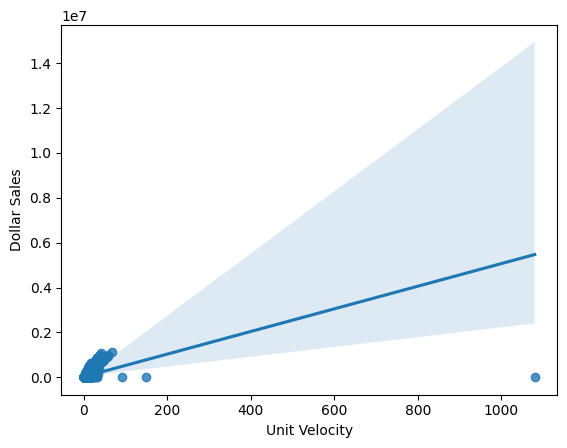

In [27]:
#Dollar Sales vs Unit velocity with outliers
sns.regplot(y=df['Dollar Sales'], x=df['Unit Velocity'], scatter=True)

<Axes: >

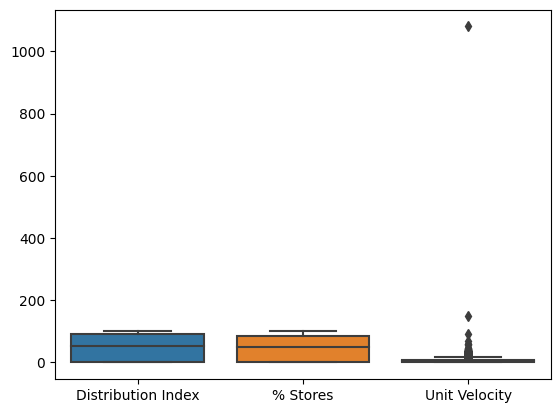

In [28]:
#Statistical Summary with outliers
sns.boxplot(df[['Distribution Index','% Stores','Unit Velocity']])

In [29]:
#Selecting suitable range for Unit Velocity
df=df[df['Unit Velocity']<120]
df=df[df['Dollar Sales']<1000000]

<Axes: xlabel='Unit Velocity', ylabel='Dollar Sales'>

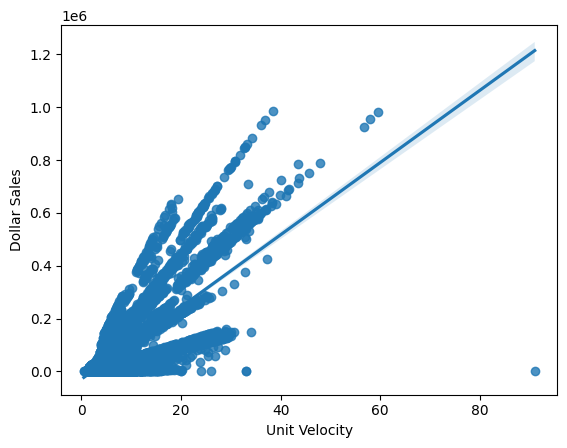

In [30]:
#Dollar Sales vs Unit velocity after removal of outliers
sns.regplot(y=df['Dollar Sales'], x=df['Unit Velocity'], scatter=True)

<Axes: >

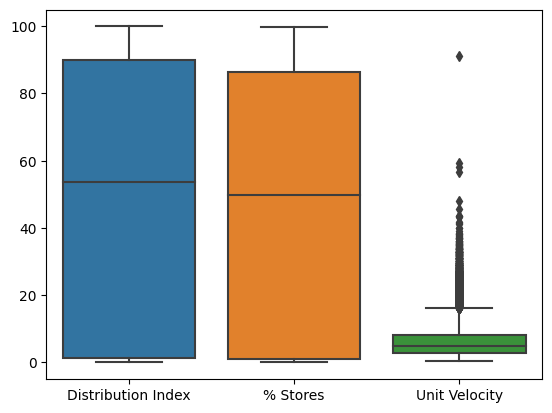

In [31]:
##Statistical Summary with outliers after removal of outliers
sns.boxplot(df[['Distribution Index','% Stores','Unit Velocity']])

##Adding Holiday and Season information in data

###Adding Holiday information

In [32]:
#Formatting Time column to find Month, Day and Year
df['Time']=df['Time'].apply(lambda x: x.strip())
df['Time']=df['Time'].apply(lambda x: x.split(" "))

df['Month']=df['Time'].apply(lambda x: x.pop(3))
df['Day']=df['Time'].apply(lambda x: x.pop(3))
df['Year']=df['Time'].apply(lambda x: x.pop(3))


In [33]:
#Removing Comma in Day information
df['Day']=df['Day'].str.replace(',','')
print(df[['Month','Day','Year']])

       Month Day  Year
489      Jan  09  2022
490      Jan  16  2022
491      Jan  23  2022
492      Jan  30  2022
493      Feb  06  2022
...      ...  ..   ...
119737   Feb  19  2023
120952   Mar  01  2020
121008   Mar  28  2021
122588   Jan  05  2020
122596   Mar  01  2020

[20712 rows x 3 columns]


In [34]:
#Replacing Month names with Month number
df['Month']=df['Month'].str.replace('Jan','1')
df['Month']=df['Month'].str.replace('Feb','2')
df['Month']=df['Month'].str.replace('Mar','3')
df['Month']=df['Month'].str.replace('Apr','4')
df['Month']=df['Month'].str.replace('May','5')
df['Month']=df['Month'].str.replace('Jun','6')
df['Month']=df['Month'].str.replace('Jul','7')
df['Month']=df['Month'].str.replace('Aug','8')
df['Month']=df['Month'].str.replace('Sep','9')
df['Month']=df['Month'].str.replace('Oct','10')
df['Month']=df['Month'].str.replace('Nov','11')
df['Month']=df['Month'].str.replace('Dec','12')

In [35]:
#Adding date column based on above extracted Month, Year and Day
df['edate'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.Day))

#Adding date column 7 days prior to added date column
df['sdate'] = df['edate'] - pd.Timedelta(days=7)

#Adding Week number based on start of week
df['Week']=df['sdate'].dt.isocalendar().week

In [36]:
#Adding US Fedral Holidays as True or False
holidays = calendar().holidays(start = df['sdate'].min(), end = df['edate'].max())
l=[any(x<=z and y>=z for z in holidays.tolist()) for x , y in zip(df['sdate'],df['edate'])]
[False, True, False, False]
df['Holiday']=l

In [37]:
#converting Holiday to Object datatype
df['Holiday']=df['Holiday'].astype('object')
df['Week']=df['Week'].astype('object')

In [38]:
df.head()

Product               Time  Dollar Sales  Unit Sales  Avg Prc/Unit  \
489       2  [1, Week, Ending]          3.78         2.0      1.890000   
490       2  [1, Week, Ending]         13.23         7.0      1.890000   
491       2  [1, Week, Ending]          4.78         3.0      1.593333   
492       2  [1, Week, Ending]         19.23        13.0      1.479231   
493       2  [1, Week, Ending]          9.67         7.0      1.381429   

     Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
489                       1.89                   1.89            0.027212   
490                       1.89                   1.89            0.087065   
491                       1.89                   1.00            0.043179   
492                       1.89                   1.00            0.100525   
493                       1.89                   1.00            0.072208   

     % Stores  Unit Velocity Month Day  Year      edate      sdate Week  \
489  0.021796       2.000000     1  09  2022 2022-01-09 2022-01-02   52   
490  0.065388       2.333333     1  16  2022 2022-01-16 2022-01-09    1   
491  0.043592       1.500000     1  23  2022 2022-01-23 2022-01-16    2   
492  0.087184       3.250000     1  30  2022 2022-01-30 2022-01-23    3   
493  0.065388       2.333333     2  06  2022 2022-02-06 2022-01-30    4   

    Holiday  
489   False  
490   False  
491    True  
492   False  
493   False

###Adding Season information

In [39]:
#Adding Season information
def get_season(i):
  if(i==12 or i==1 or i==2):
    return "Winter"
  elif(i==3 or i==4 or i==5):
    return "Spring"
  elif(i==6 or i==7 or i==8):
    return "Summer"
  else:
    return "Fall"



In [40]:
#Applying Season to all rows
df['Season']=df['Month'].apply(lambda x: get_season(int(x)))

In [41]:
#Number of Seasons
df['Season'].nunique()

4

In [42]:
#Remove Time column from data
df=df.drop(columns=['Time'])

In [43]:
df.head()

Product  Dollar Sales  Unit Sales  Avg Prc/Unit  \
489       2          3.78         2.0      1.890000   
490       2         13.23         7.0      1.890000   
491       2          4.78         3.0      1.593333   
492       2         19.23        13.0      1.479231   
493       2          9.67         7.0      1.381429   

     Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
489                       1.89                   1.89            0.027212   
490                       1.89                   1.89            0.087065   
491                       1.89                   1.00            0.043179   
492                       1.89                   1.00            0.100525   
493                       1.89                   1.00            0.072208   

     % Stores  Unit Velocity Month Day  Year      edate      sdate Week  \
489  0.021796       2.000000     1  09  2022 2022-01-09 2022-01-02   52   
490  0.065388       2.333333     1  16  2022 2022-01-16 2022-01-09    1   
491  0.043592       1.500000     1  23  2022 2022-01-23 2022-01-16    2   
492  0.087184       3.250000     1  30  2022 2022-01-30 2022-01-23    3   
493  0.065388       2.333333     2  06  2022 2022-02-06 2022-01-30    4   

    Holiday  Season  
489   False  Winter  
490   False  Winter  
491    True  Winter  
492   False  Winter  
493   False  Winter

##Data Exploration

In [44]:
#Top 5 Products by Dollar Sales
df_top_product = df.groupby(by=['Product'], as_index=False)['Dollar Sales'].sum()
df_top_product.sort_values('Dollar Sales', ascending=False)[:5]

Product  Dollar Sales
143     382  1.371574e+08
164     426  1.187526e+08
40      176  9.187535e+07
27      153  6.960450e+07
51      196  5.627026e+07

<Axes: xlabel='Week'>

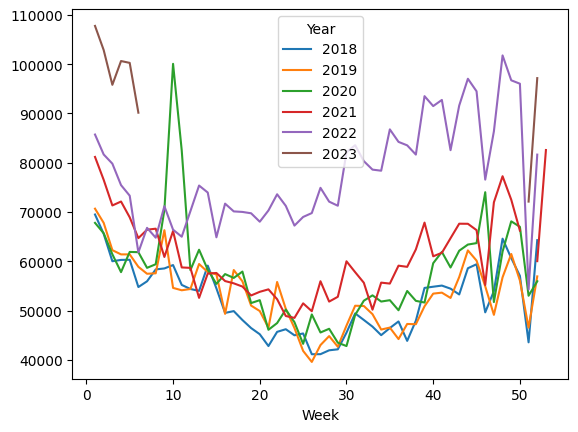

In [45]:
#Sales by Year
weekly_sales = pd.pivot_table(df, values = "Dollar Sales", columns = "Year", index = "Week")
weekly_sales.plot()

<Axes: xlabel='Unit Velocity'>

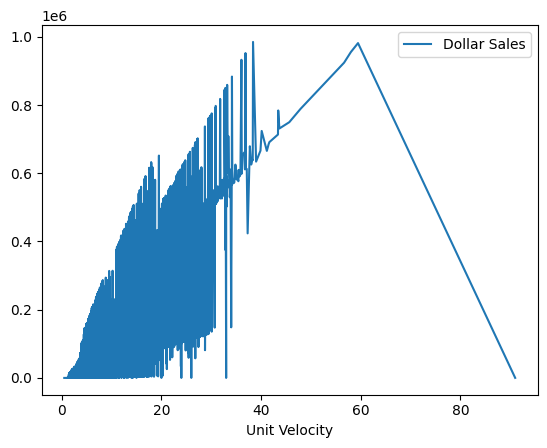

In [46]:
#Sales by Unit Velocity
sales_unit_velocity = pd.pivot_table(df, values = "Dollar Sales", index= "Unit Velocity")
sales_unit_velocity.plot()

<Axes: xlabel='Distribution Index'>

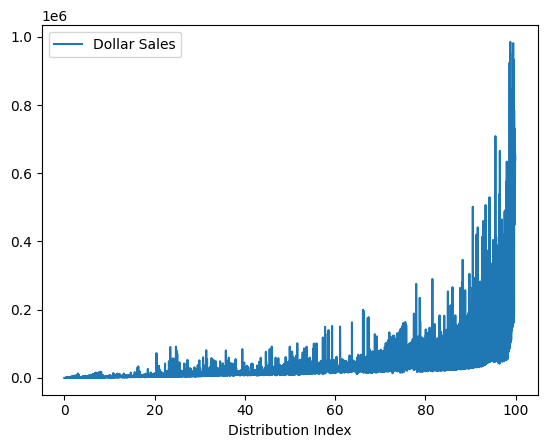

In [47]:
#Sales by distribution index
sales_dist_idx = pd.pivot_table(df, values = "Dollar Sales", index= "Distribution Index")
sales_dist_idx.plot()

In [48]:
# Creating column's subsets as per the datatype
dataset_dtypes = df.dtypes.reset_index()
dataset_dtypes.columns = ['variable', 'dtype']
# Getting the categorical columns
cat_cols = dataset_dtypes[dataset_dtypes['dtype']=='object']['variable'].tolist()
# Getting the continuos columns
cont_cols = dataset_dtypes[dataset_dtypes['dtype']!='object']['variable'].tolist()

print("Categorical Columns:", cat_cols)
print()
print("Continuos Columns:", cont_cols)

Categorical Columns: ['Product', 'Month', 'Day', 'Year', 'Week', 'Holiday', 'Season']

Continuos Columns: ['Dollar Sales', 'Unit Sales', 'Avg Prc/Unit', 'Non Promoted-Avg Prc/Unit', 'Promoted Avg Prc/Unit', 'Distribution Index', '% Stores', 'Unit Velocity', 'edate', 'sdate']


In [49]:
df[cat_cols].describe().T

count unique     top   freq
Product  20712    198     414    268
Month    20712     12       1   2100
Day      20712     31      22    713
Year     20712      6    2018   4441
Week     20712     53       4    476
Holiday  20712      2   False  16549
Season   20712      4  Winter   5580

In [50]:
df[cont_cols].describe(percentiles=[.05,.25,.50,.75,.95]).round(2).T

count      mean        std   min    5%     25%  \
Dollar Sales               20712.0  60736.78  101426.44  0.01  4.00  395.18   
Unit Sales                 20712.0  20525.73   28060.06  1.00  1.00  170.02   
Avg Prc/Unit               20712.0      2.92       1.61  0.01  0.98    2.00   
Non Promoted-Avg Prc/Unit  20712.0      2.94       1.62  0.01  0.98    2.07   
Promoted Avg Prc/Unit      20712.0      2.73       1.60  0.01  0.89    1.75   
Distribution Index         20712.0     49.35      40.05  0.00  0.03    1.29   
% Stores                   20712.0     47.07      39.12  0.02  0.02    1.07   
Unit Velocity              20712.0      6.63       5.75  0.50  1.00    2.97   

                                50%       75%        95%        max  
Dollar Sales               24075.49  76374.24  263704.13  984973.79  
Unit Sales                 10253.50  28429.00   79640.45  271607.00  
Avg Prc/Unit                   2.57      3.55       5.05      18.24  
Non Promoted-Avg Prc/Unit      2.58      3.56       5.05      18.24  
Promoted Avg Prc/Unit          2.48      3.27       4.91      18.24  
Distribution Index            53.65     90.03      98.46      99.91  
% Stores                      49.69     86.39      97.56      99.85  
Unit Velocity                  5.00      8.24      18.35      91.00

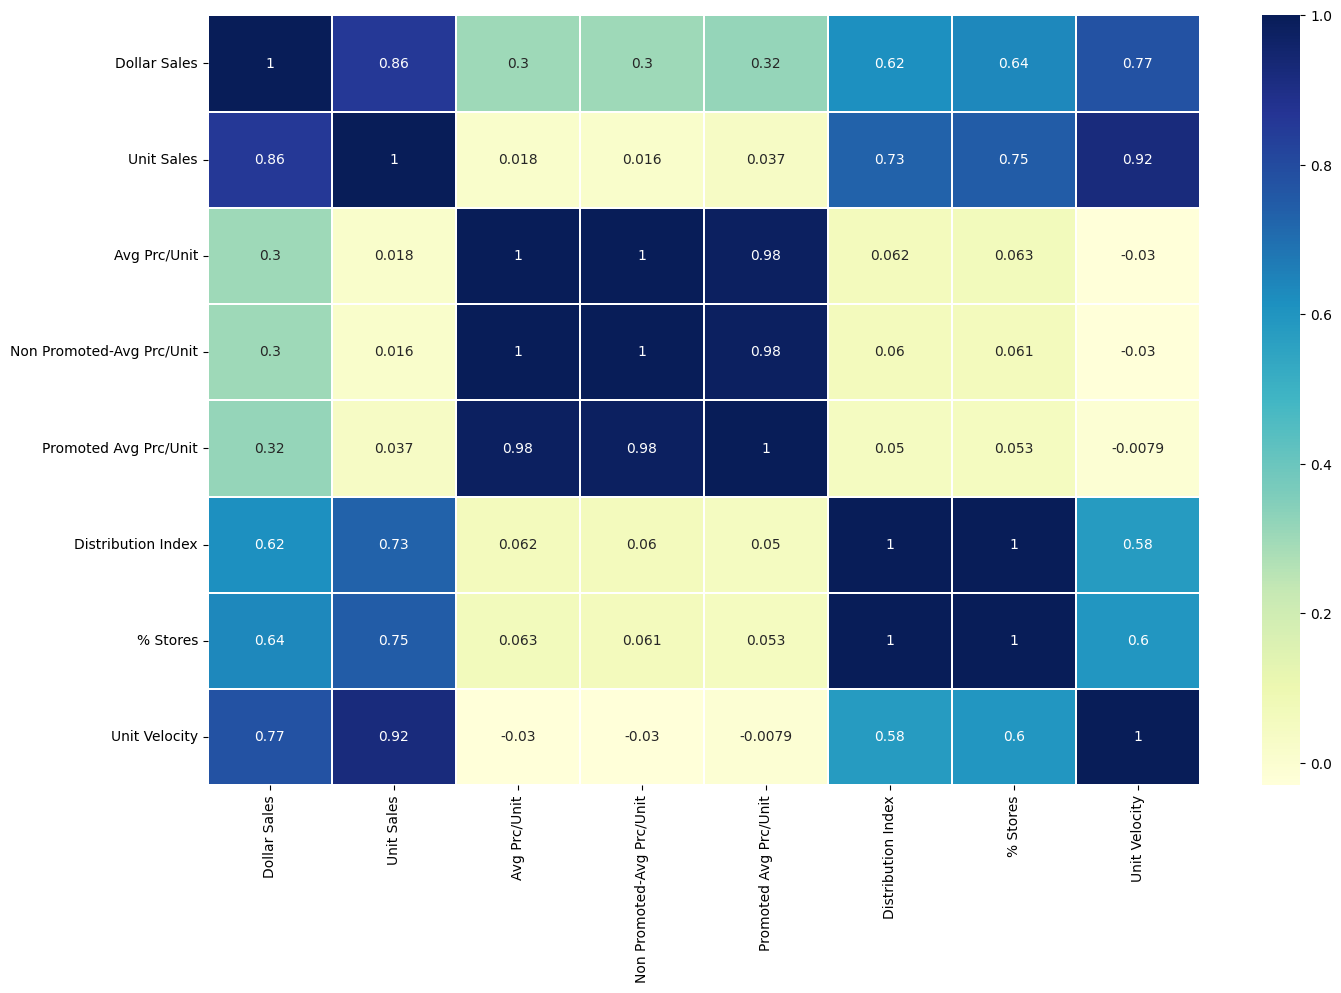

In [51]:
#Correlation between contious columns
fig = plt.figure(figsize=(16, 10));
sns.heatmap(df[cont_cols].corr(), cmap="YlGnBu",  annot=True, linewidths ='.02');

<Axes: xlabel='Holiday', ylabel='Dollar Sales'>

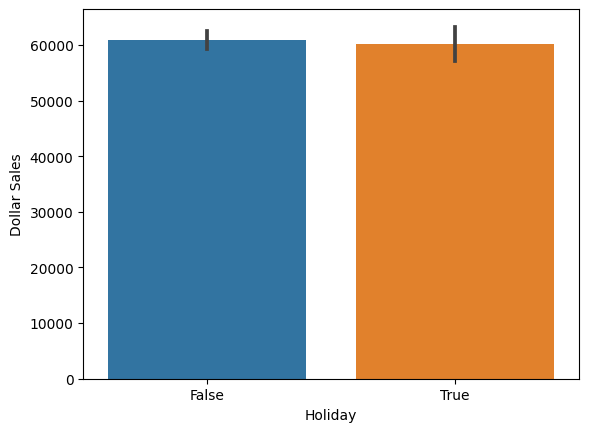

In [52]:
#Dollar Sales with respect to holidays
sns.barplot(y=df['Dollar Sales'], x=df['Holiday'])

<Axes: xlabel='Season', ylabel='Dollar Sales'>

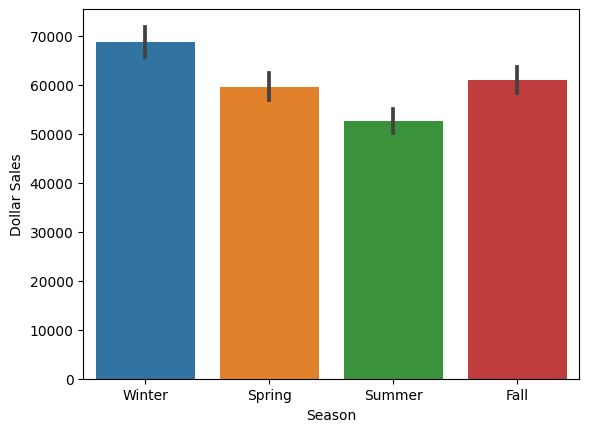

In [53]:
#Dollar Sales with respect to season
sns.barplot(y=df['Dollar Sales'], x=df['Season'])

<Axes: xlabel='Unit Velocity', ylabel='Dollar Sales'>

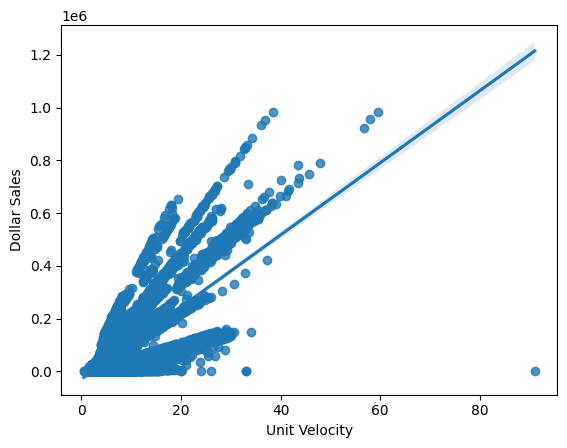

In [54]:
#Dollar Sales with respect to Unit Velocity
sns.regplot(y=df['Dollar Sales'], x=df['Unit Velocity'], scatter=True)

<Axes: xlabel='% Stores', ylabel='Dollar Sales'>

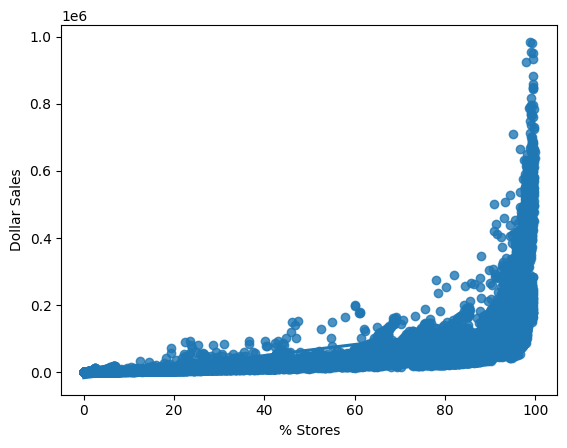

In [55]:
#Dollar Sales with respect to % Stores
sns.regplot(y=df['Dollar Sales'], x=df['% Stores'], scatter=True)

<Axes: xlabel='Distribution Index', ylabel='Dollar Sales'>

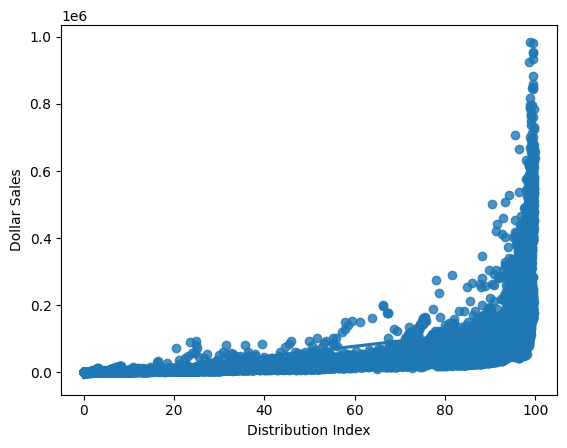

In [56]:
#Dollar Sales with respect to Distribution index
sns.regplot(y=df['Dollar Sales'], x=df['Distribution Index'], scatter=True)

<Axes: xlabel='Avg Prc/Unit', ylabel='Dollar Sales'>

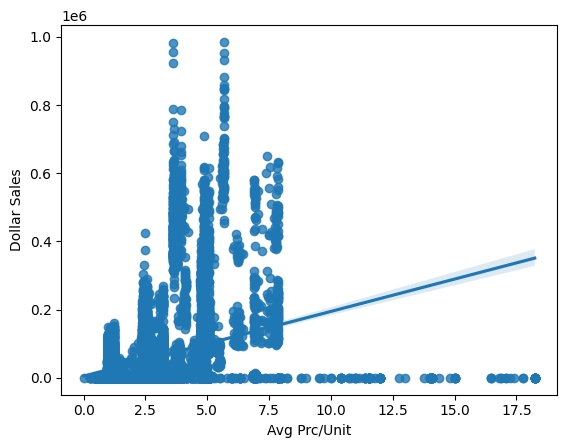

In [57]:
#Dollar Sales with respect to Avg Prc/Unit
sns.regplot(y=df['Dollar Sales'], x=df['Avg Prc/Unit'], scatter=True)

<Axes: xlabel='Non Promoted-Avg Prc/Unit', ylabel='Dollar Sales'>

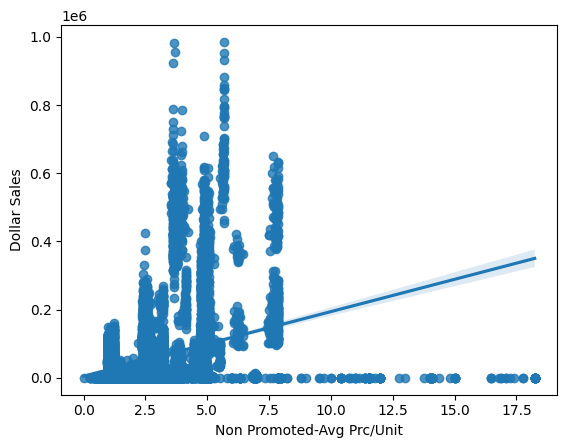

In [58]:
#Dollar Sales with respect to Non Promoted Avg Prc/Unit
sns.regplot(y=df['Dollar Sales'], x=df['Non Promoted-Avg Prc/Unit'], scatter=True)

<Axes: xlabel='Promoted Avg Prc/Unit', ylabel='Dollar Sales'>

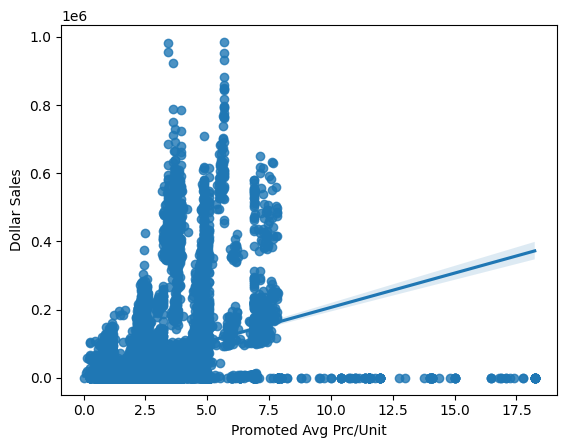

In [59]:
#Dollar Sales with respect to Promoted Avg Prc/Unit
sns.regplot(y=df['Dollar Sales'], x=df['Promoted Avg Prc/Unit'], scatter=True)

<Axes: >

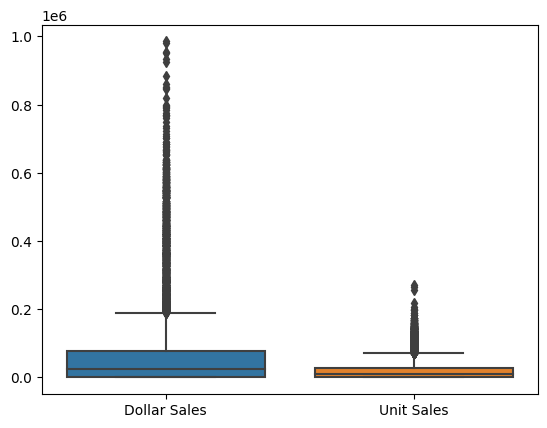

In [60]:
#Statistical summary of Dollar sales and Unit Sales
sns.boxplot(df[['Dollar Sales','Unit Sales']])

<Axes: >

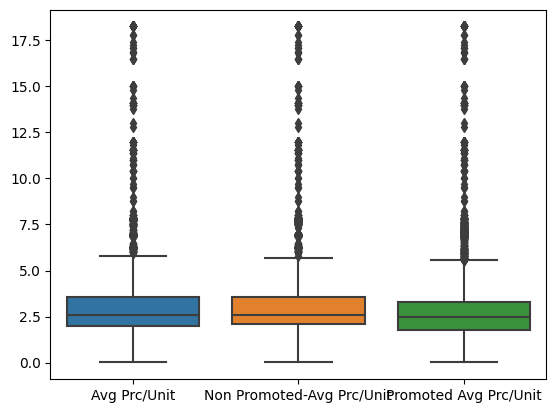

In [61]:
#Statistical summary of Avg Prc/Unit, Promoted - Avg Prc/Unit and Non Promoted Avg Prc/Unit
sns.boxplot(df[['Avg Prc/Unit','Non Promoted-Avg Prc/Unit','Promoted Avg Prc/Unit']])

<Axes: >

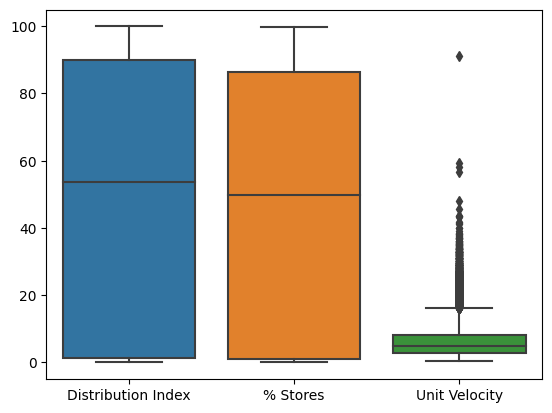

In [62]:
#Statistical summary of Distribution index, % Stores and Unit Velocity
sns.boxplot(df[['Distribution Index','% Stores','Unit Velocity']])

##Feature Selection Using Random Forest Regressor

In [63]:
#Create temporary DataFrame with cleaned data
df_tmp=df.drop(columns=['Product','sdate','edate'])

In [64]:
df_tmp.head()

Dollar Sales  Unit Sales  Avg Prc/Unit  Non Promoted-Avg Prc/Unit  \
489          3.78         2.0      1.890000                       1.89   
490         13.23         7.0      1.890000                       1.89   
491          4.78         3.0      1.593333                       1.89   
492         19.23        13.0      1.479231                       1.89   
493          9.67         7.0      1.381429                       1.89   

     Promoted Avg Prc/Unit  Distribution Index  % Stores  Unit Velocity Month  \
489                   1.89            0.027212  0.021796       2.000000     1   
490                   1.89            0.087065  0.065388       2.333333     1   
491                   1.00            0.043179  0.043592       1.500000     1   
492                   1.00            0.100525  0.087184       3.250000     1   
493                   1.00            0.072208  0.065388       2.333333     2   

    Day  Year Week Holiday  Season  
489  09  2022   52   False  Winter  
490  16  2022    1   False  Winter  
491  23  2022    2    True  Winter  
492  30  2022    3   False  Winter  
493  06  2022    4   False  Winter

In [65]:
#Encoding Categorical Data
enc_data = pd.get_dummies(df_tmp, columns=['Holiday','Season'], drop_first=True)
print("Shape of the dataset after encoding:", enc_data.shape)

Shape of the dataset after encoding: (20712, 16)


In [66]:
#Assign X and y values
X=enc_data.drop(['Dollar Sales'], axis=1)
y=enc_data['Dollar Sales']

In [67]:
#Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Feature ranking:
1. feature 4 (0.199294)
2. feature 0 (0.197191)
3. feature 5 (0.176996)
4. feature 6 (0.158159)
5. feature 3 (0.104532)
6. feature 1 (0.085568)
7. feature 2 (0.068561)
8. feature 9 (0.003871)
9. feature 10 (0.002027)
10. feature 7 (0.001549)
11. feature 8 (0.000736)
12. feature 14 (0.000626)
13. feature 13 (0.000593)
14. feature 12 (0.000203)
15. feature 11 (0.000093)


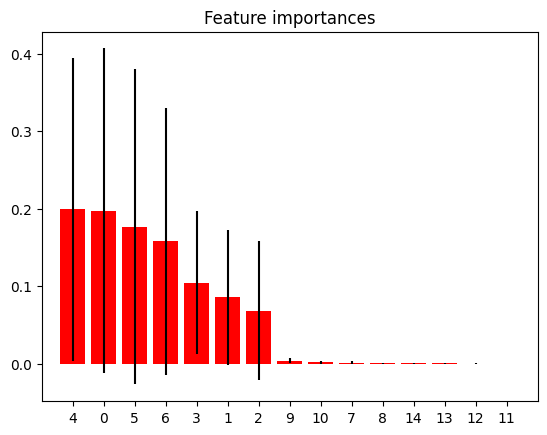

In [68]:
#defining Random Forest Regressor
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)
#RobustScaler is used for sacaling data
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

##Regression Models

In [69]:
#Based on feature importance pass only top 7 features
new_enc_data= enc_data[['Dollar Sales','Unit Sales','Avg Prc/Unit','Non Promoted-Avg Prc/Unit','Promoted Avg Prc/Unit','Distribution Index','% Stores','Unit Velocity']]

In [70]:
#Select target variable and other variables in X and y
X=new_enc_data.drop(['Dollar Sales'], axis=1)
y=new_enc_data['Dollar Sales']

#Split the data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
#Selecting models
Reg_model = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
    ]

name = []
score = []
models = []
mse = []
rmse = []
i = 0
for reg in Reg_model:
    reg.fit(X_train, y_train)
    name.append(type(reg).__name__)
    score.append(reg.score(X_train, y_train))
    models.append(reg)
    mse.append(mean_squared_error(reg.predict(X_test), y_test))
    rmse.append(mean_squared_error(reg.predict(X_test), y_test, squared=False))

In [72]:
#Printing Performance of Models
df_score = pd.DataFrame(list(zip(name,mse,rmse,score, models)),columns=['name','mse','rmse','score',"model"])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['score'],inplace=True)
df_score

mse           rmse     score  \
name                                                               
SVR                        1.187074e+10  108952.928685 -0.095518   
LinearRegression           1.982403e+09   44524.188164  0.820907   
AdaBoostRegressor          1.207684e+09   34751.750812  0.887170   
GradientBoostingRegressor  4.454477e+07    6674.186964  0.996589   
LGBMRegressor              3.646507e+07    6038.631395  0.998052   
RandomForestRegressor      9.261807e+06    3043.321639  0.999859   
XGBRegressor               1.783245e+07    4222.848232  0.999908   
DecisionTreeRegressor      2.509896e+07    5009.885793  1.000000   

                                                                       model  
name                                                                          
SVR                                                                    SVR()  
LinearRegression                                          LinearRegression()  
AdaBoostRegressor          (DecisionTreeRegressor(max_depth=3, random_sta...  
GradientBoostingRegressor  ([DecisionTreeRegressor(criterion='friedman_ms...  
LGBMRegressor                                                LGBMRegressor()  
RandomForestRegressor      (DecisionTreeRegressor(max_features=1.0, rando...  
XGBRegressor               XGBRegressor(base_score=None, booster=None, ca...  
DecisionTreeRegressor                                DecisionTreeRegressor()

##Time Series Model

In [73]:
#Input Data
df.head()

Product  Dollar Sales  Unit Sales  Avg Prc/Unit  \
489       2          3.78         2.0      1.890000   
490       2         13.23         7.0      1.890000   
491       2          4.78         3.0      1.593333   
492       2         19.23        13.0      1.479231   
493       2          9.67         7.0      1.381429   

     Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
489                       1.89                   1.89            0.027212   
490                       1.89                   1.89            0.087065   
491                       1.89                   1.00            0.043179   
492                       1.89                   1.00            0.100525   
493                       1.89                   1.00            0.072208   

     % Stores  Unit Velocity Month Day  Year      edate      sdate Week  \
489  0.021796       2.000000     1  09  2022 2022-01-09 2022-01-02   52   
490  0.065388       2.333333     1  16  2022 2022-01-16 2022-01-09    1   
491  0.043592       1.500000     1  23  2022 2022-01-23 2022-01-16    2   
492  0.087184       3.250000     1  30  2022 2022-01-30 2022-01-23    3   
493  0.065388       2.333333     2  06  2022 2022-02-06 2022-01-30    4   

    Holiday  Season  
489   False  Winter  
490   False  Winter  
491    True  Winter  
492   False  Winter  
493   False  Winter

In [74]:
#Removing Start of week information
df=df.drop(columns=['sdate'])

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20712 entries, 489 to 122596
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Product                    20712 non-null  object        
 1   Dollar Sales               20712 non-null  float64       
 2   Unit Sales                 20712 non-null  float64       
 3   Avg Prc/Unit               20712 non-null  float64       
 4   Non Promoted-Avg Prc/Unit  20712 non-null  float64       
 5   Promoted Avg Prc/Unit      20712 non-null  float64       
 6   Distribution Index         20712 non-null  float64       
 7   % Stores                   20712 non-null  float64       
 8   Unit Velocity              20712 non-null  float64       
 9   Month                      20712 non-null  object        
 10  Day                        20712 non-null  object        
 11  Year                       20712 non-null  object        
 12  e

In [76]:
#seting date as index
df.set_index('edate', inplace=True)

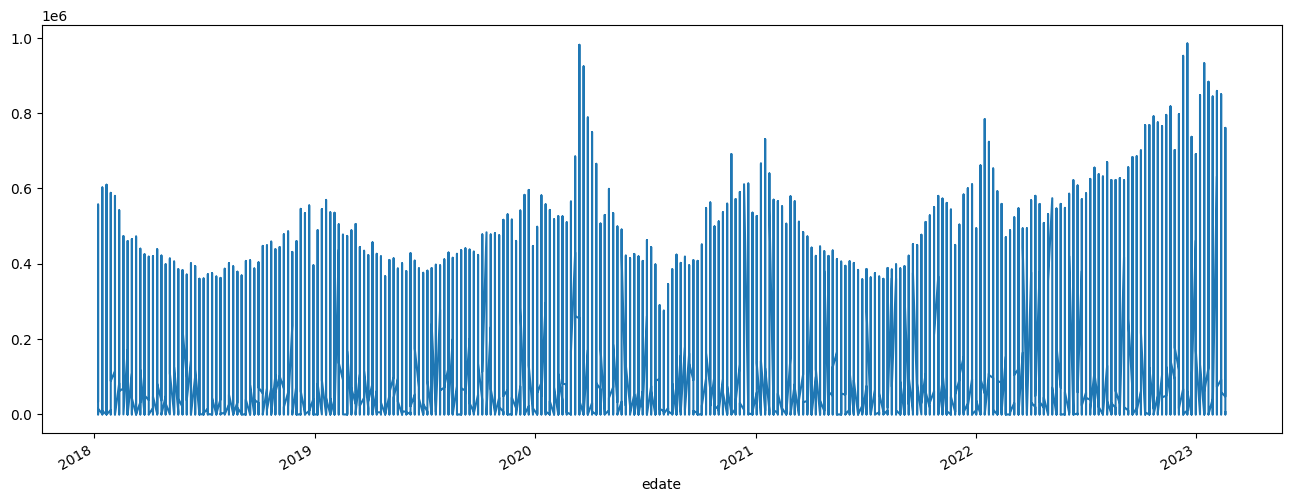

In [77]:
#Trend of Dollar Sales
plt.figure(figsize=(16,6))
df['Dollar Sales'].plot()
plt.show()

In [78]:
#resample data as weekly
df_week = df.resample('W').mean()

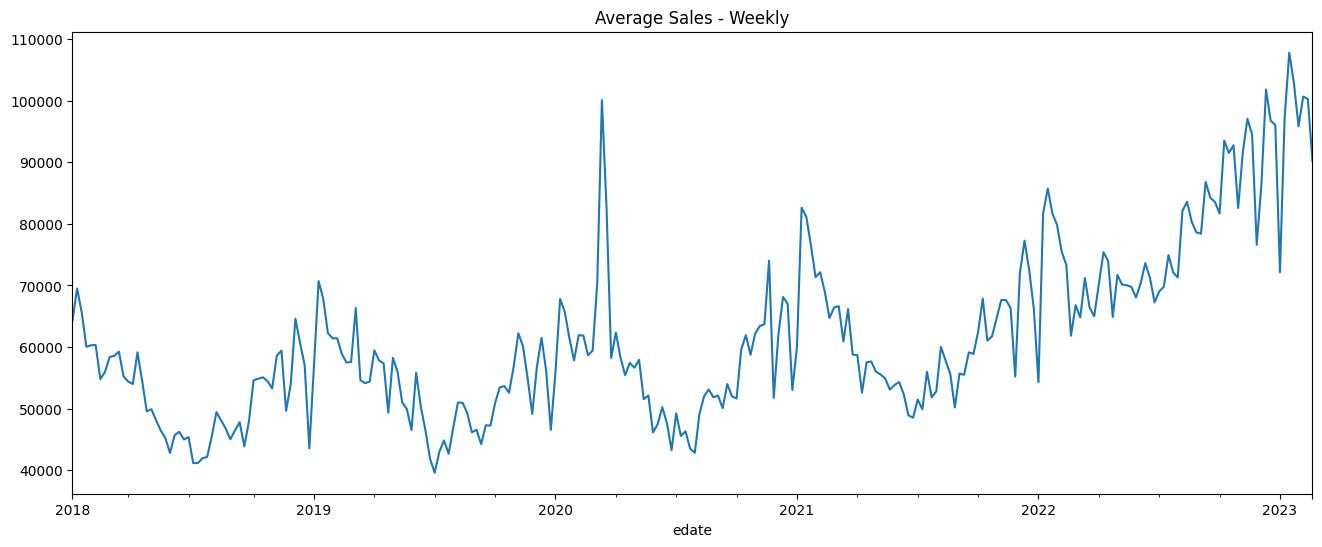

In [79]:
#Trend of Average weekly Sales
plt.figure(figsize=(16,6))
df_week['Dollar Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [80]:
df_month = df.resample('MS').mean() # resampling as monthly

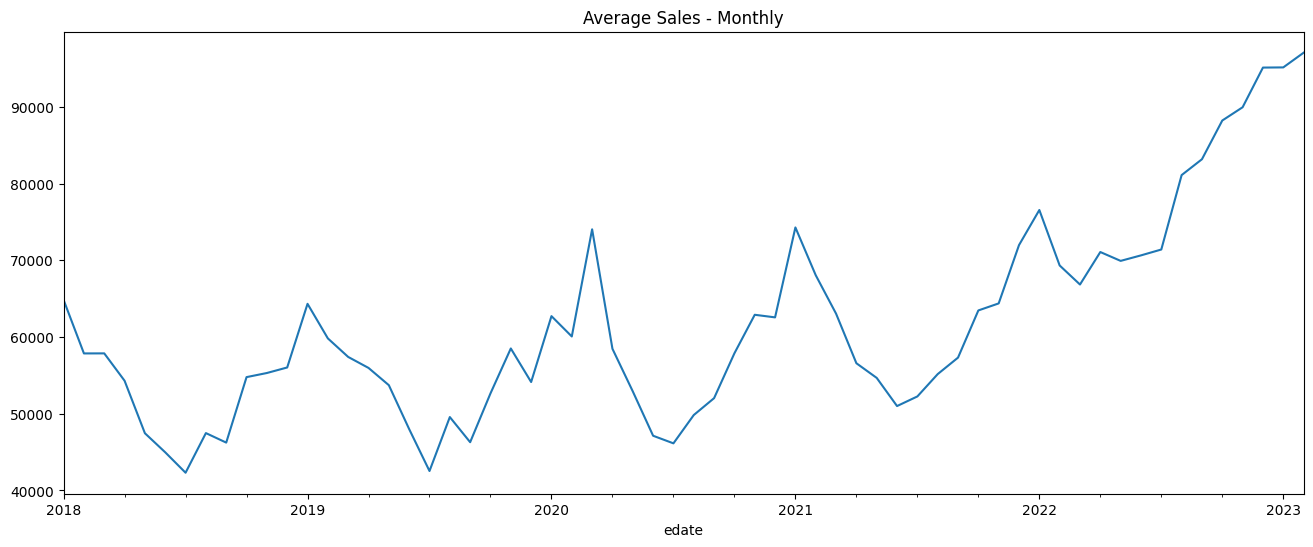

In [81]:
#Trend of Monthly Average Sales
plt.figure(figsize=(16,6))
df_month['Dollar Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

In [82]:
# finding 2-weeks rolling mean and std
rol_mean = df_week['Dollar Sales'].rolling(window=2, center=False).mean()
rol_std = df_week['Dollar Sales'].rolling(window=2, center=False).std()

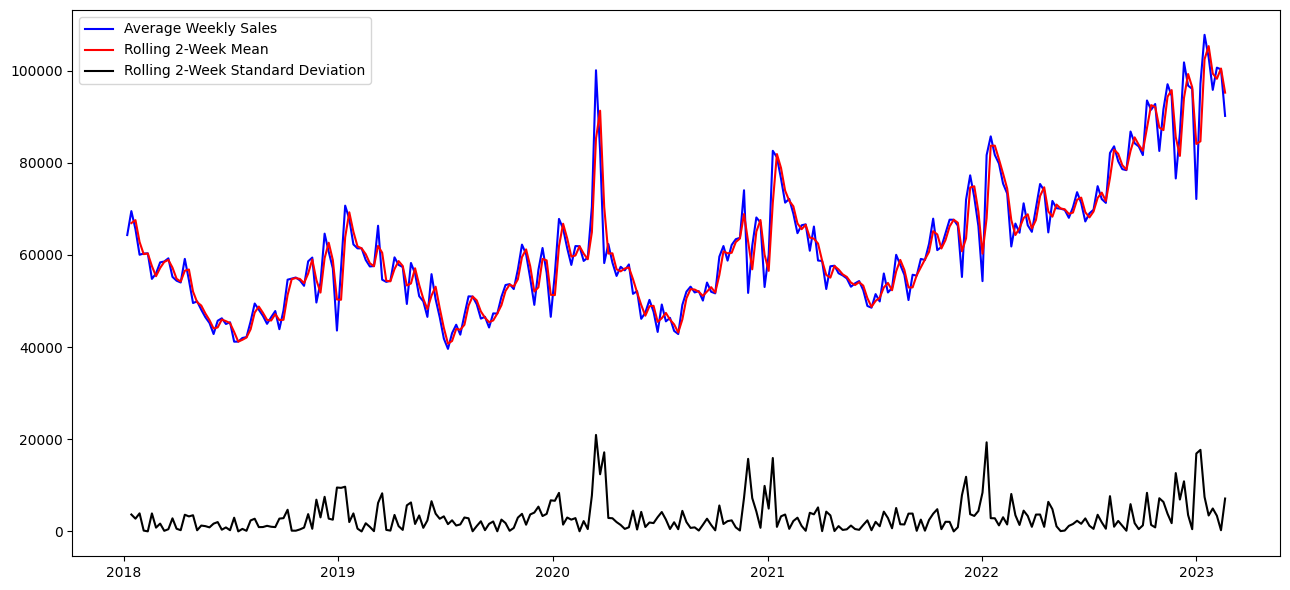

In [83]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Dollar Sales'], color='blue',label='Average Weekly Sales')
ax.plot(rol_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(rol_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [84]:
#Split data for training and validation
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)


Train: (187, 8)
Test: (81, 8)


In [85]:
#Asign variables to X and y
target = "Dollar Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except Dollar Sales

# assigning train-test X-y values
X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

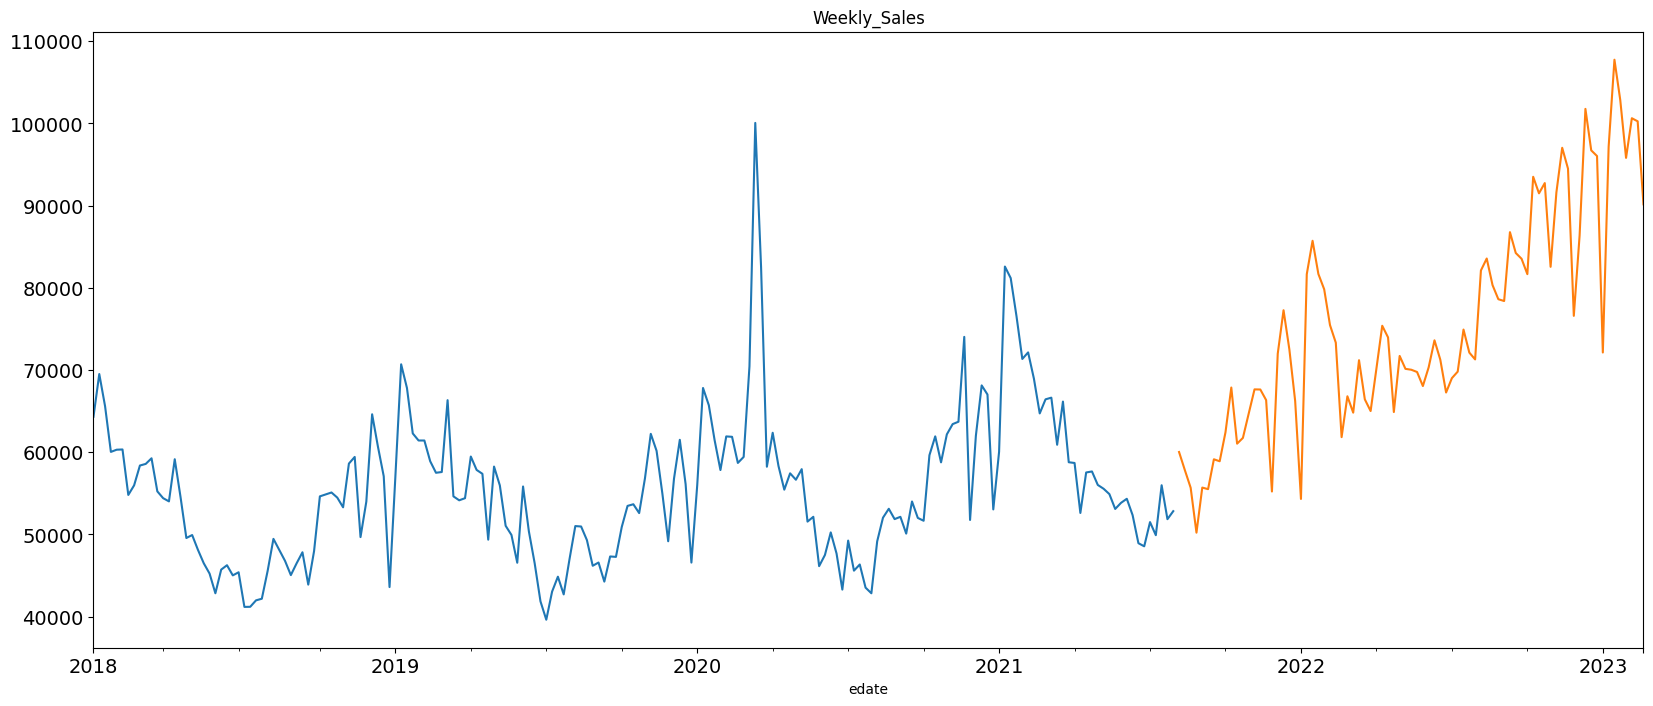

In [86]:
train_data['Dollar Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Dollar Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [87]:
#Using Adfuller Test for checking stationary data
adfuller(df_week['Dollar Sales'])

(-1.0025050460457687,
 0.7523495470139271,
 9,
 258,
 {'1%': -3.455952927706342,
  '5%': -2.8728086526320302,
  '10%': -2.572774990685656},
 5070.354406759576)

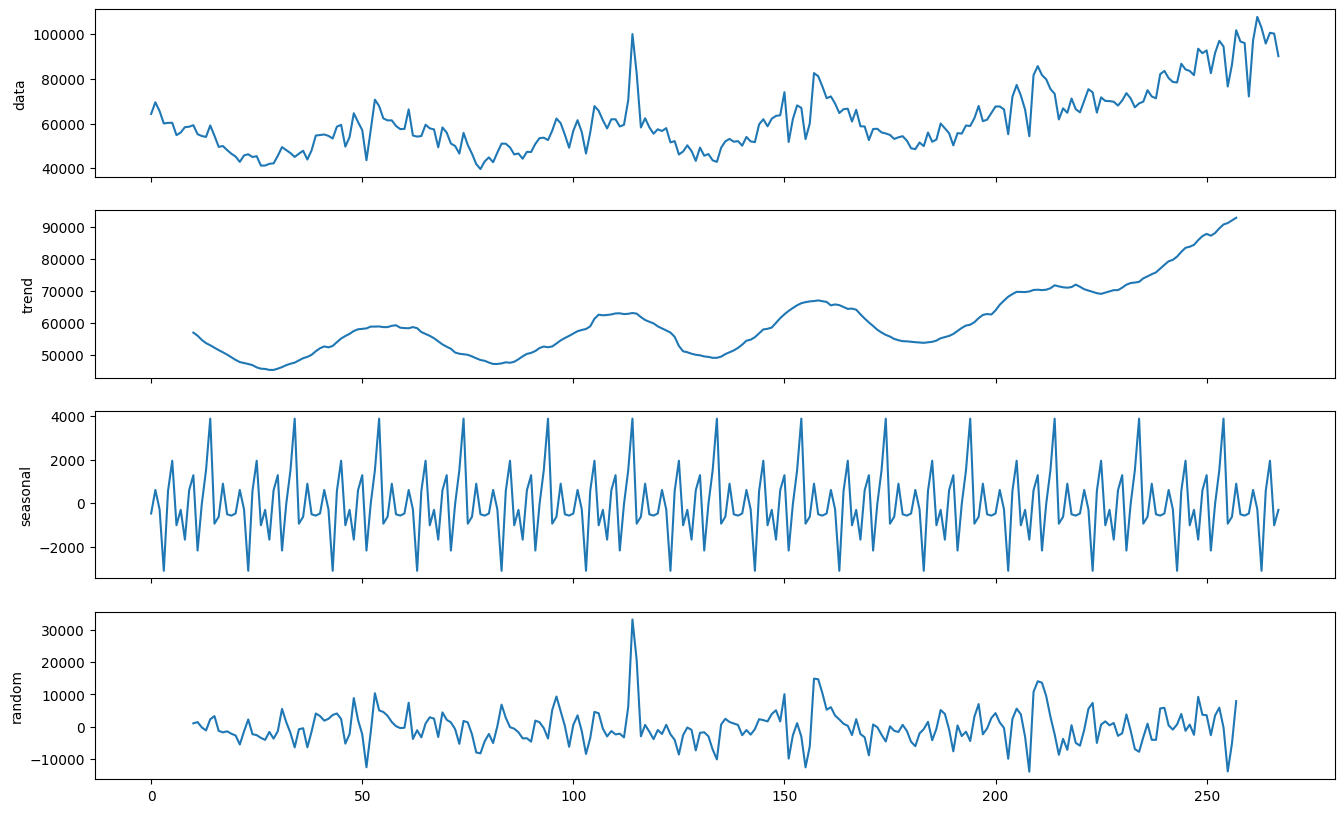

In [88]:
 #decomposing of weekly data
decomposed = decompose(df_week['Dollar Sales'].values, 'additive', m=20)
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()


In [89]:
#creating difference values
df_week_diff = df_week['Dollar Sales'].diff().dropna()

In [90]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

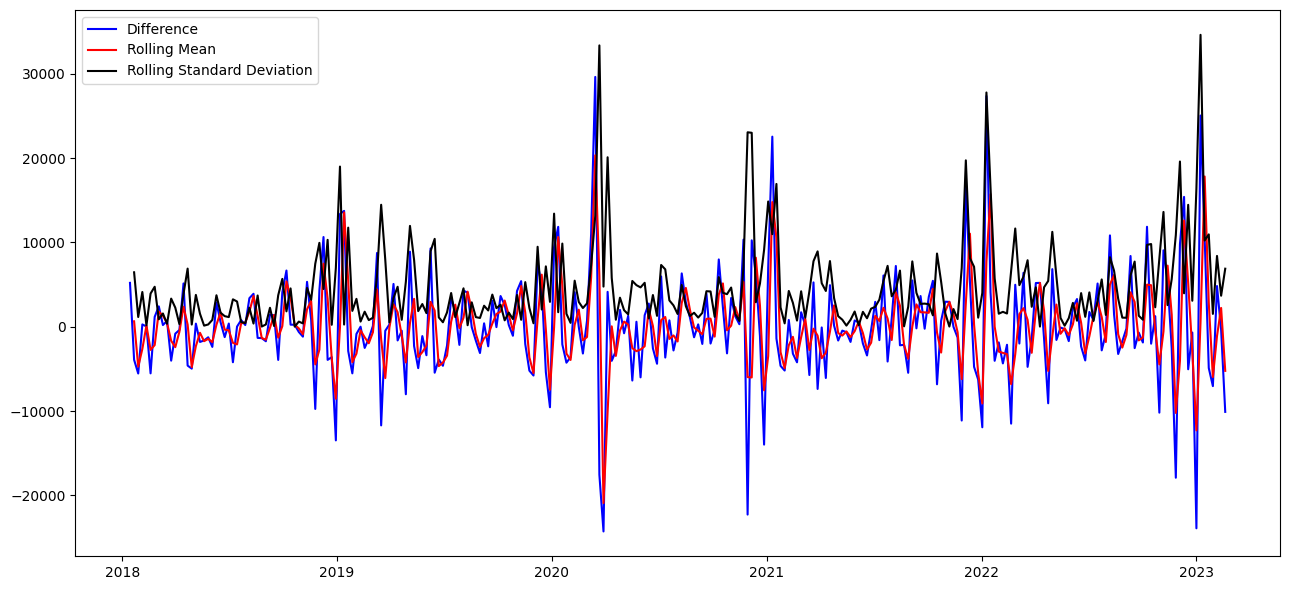

In [91]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [92]:
 #shifting the data
df_week_lag = df_week['Dollar Sales'].shift().dropna()


In [93]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

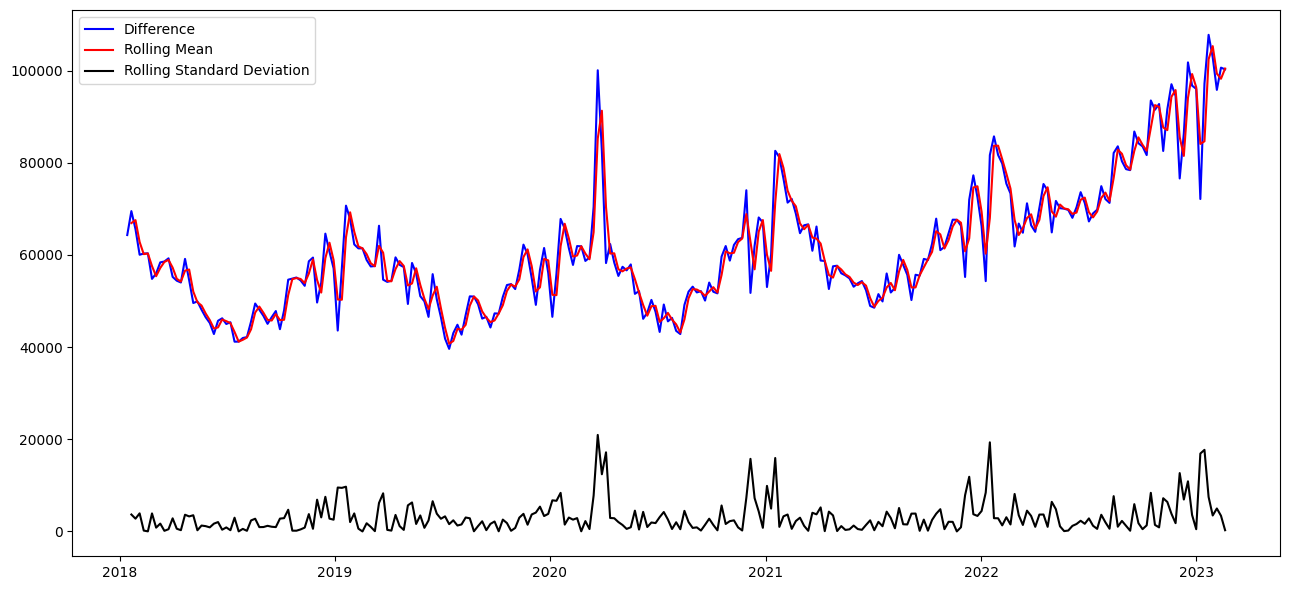

In [94]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [95]:
#taking log of data
logged_week = np.log1p(df_week['Dollar Sales']).dropna()

In [96]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

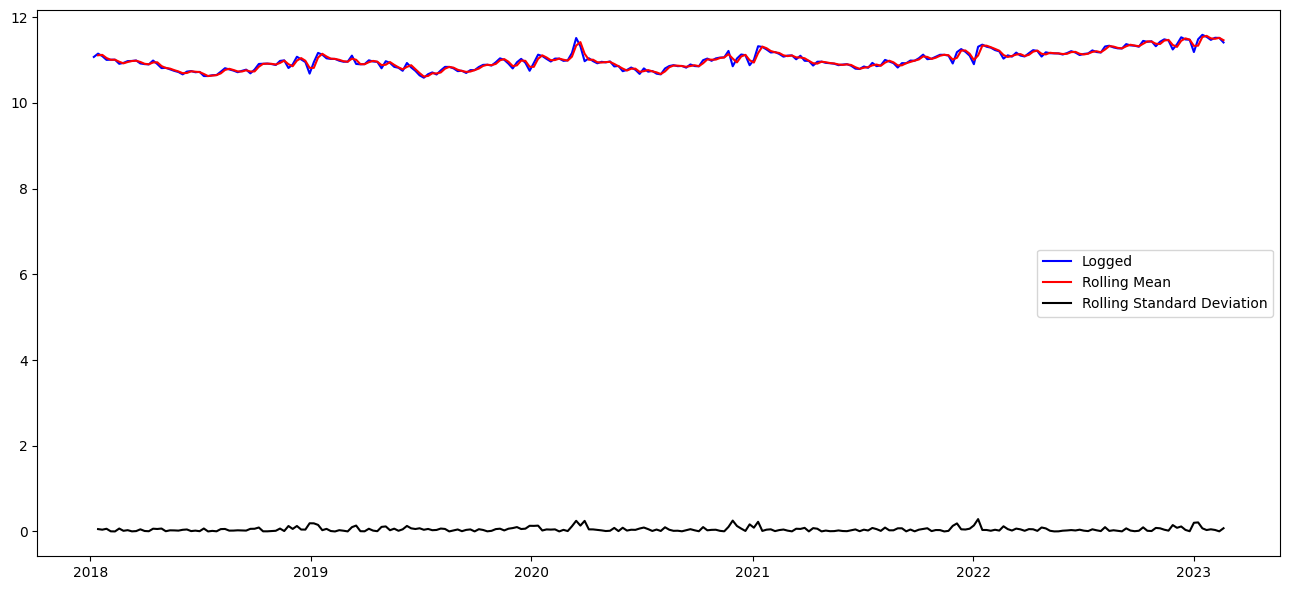

In [97]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [98]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]


In [99]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=3767.033, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=3763.579, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=3739.193, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3741.407, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=3739.910, Time=0.09 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=3740.274, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=3767.958, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=3750.900, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=3741.138, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3741.152, Time=0.44 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=3740.156, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=3741.219, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=3735.469, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=3737.222, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=3735.652, Time=0.32 sec
 ARIMA(3,0

ARIMA(maxiter=200, order=(3, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

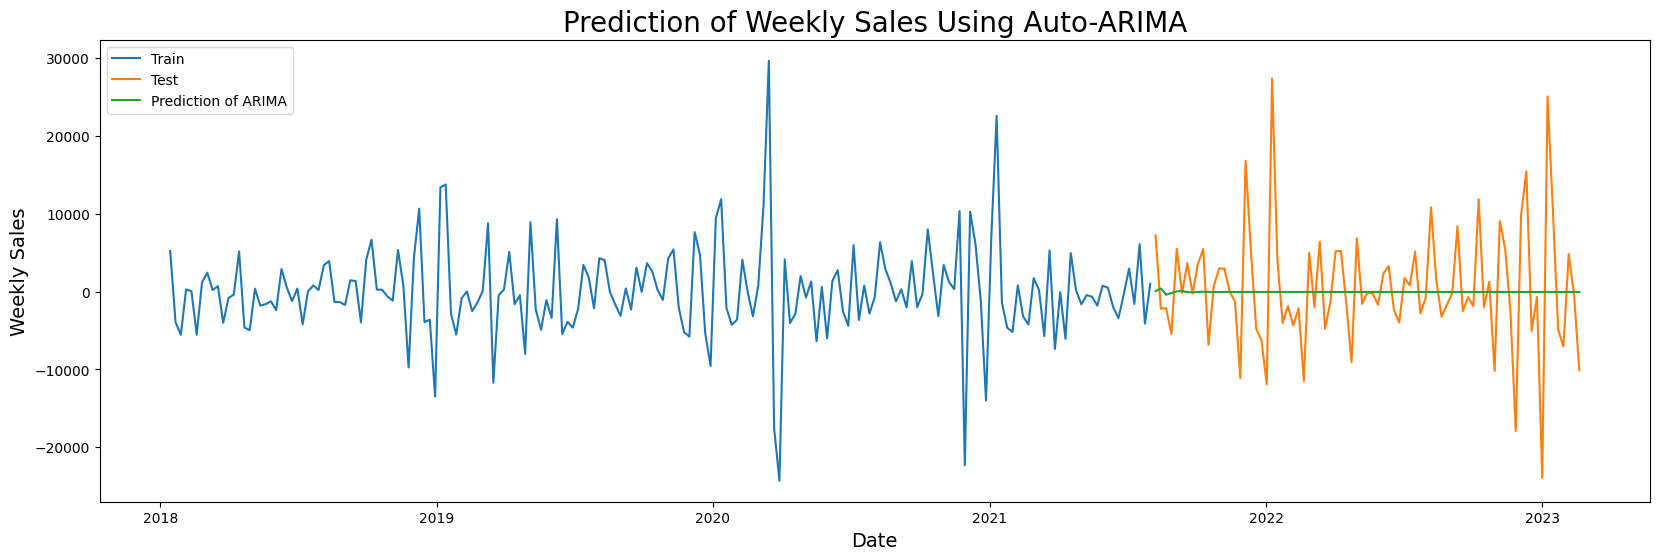

In [100]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

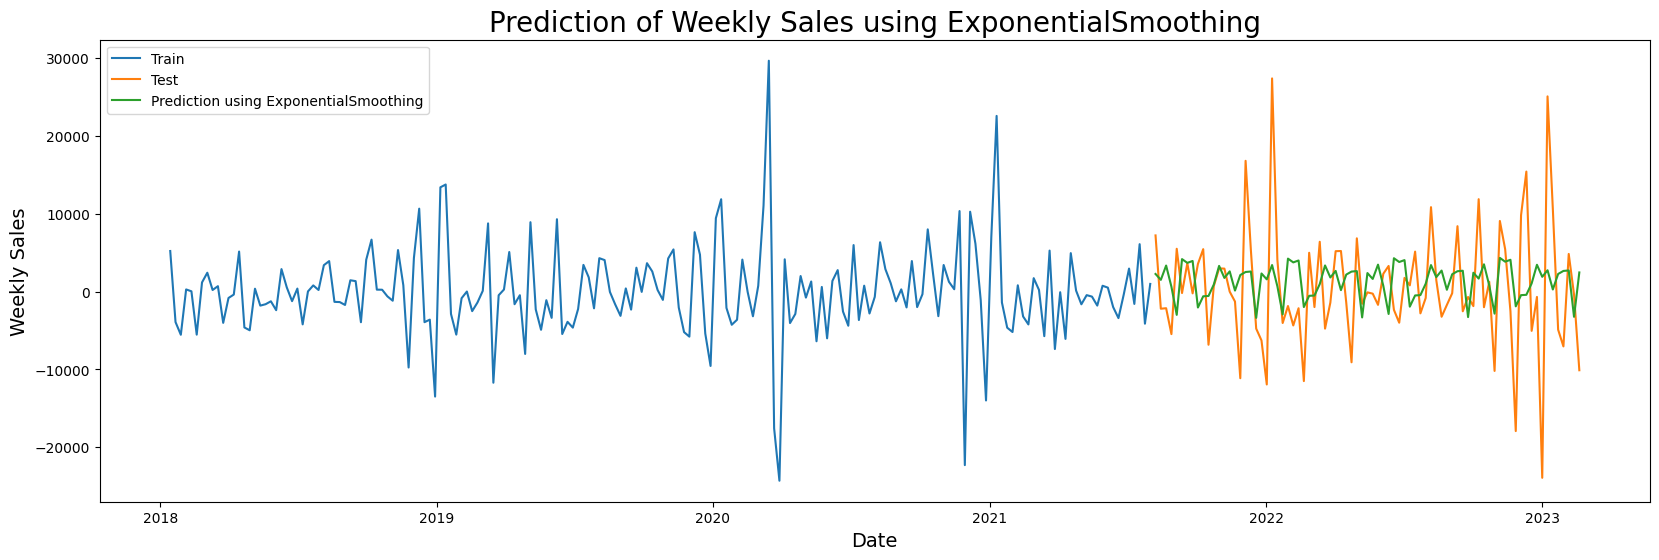

In [101]:
model_exp_smo = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_exp_smo.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [102]:
#Evaluating model using MSE
mean_squared_error(test_data_diff, y_pred)

62442376.06387964

In [103]:
#Evaluating model using RMSE
mean_squared_error(test_data_diff, y_pred, squared=False)

7902.048852283795

##GridSearchCV Estimation and Pipeline

In [104]:
#Making Pipeline
lin_reg= make_pipeline(BinaryEncoder(cols=['Holiday','Season']),StandardScaler(),PolynomialFeatures(degree=2),LinearRegression())

In [105]:
#Define GridSearchCV
grid_search = GridSearchCV(estimator= lin_reg,param_grid={'polynomialfeatures__degree':[2,3]},cv=5,scoring='r2')

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20712 entries, 2022-01-09 to 2020-03-01
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Product                    20712 non-null  object 
 1   Dollar Sales               20712 non-null  float64
 2   Unit Sales                 20712 non-null  float64
 3   Avg Prc/Unit               20712 non-null  float64
 4   Non Promoted-Avg Prc/Unit  20712 non-null  float64
 5   Promoted Avg Prc/Unit      20712 non-null  float64
 6   Distribution Index         20712 non-null  float64
 7   % Stores                   20712 non-null  float64
 8   Unit Velocity              20712 non-null  float64
 9   Month                      20712 non-null  object 
 10  Day                        20712 non-null  object 
 11  Year                       20712 non-null  object 
 12  Week                       20712 non-null  object 
 13  Holiday                    20

In [107]:
#Remove Product information
df=df.drop(columns=['Product'])

In [108]:
#Assign X and y values
X=df.drop(['Dollar Sales'], axis=1)
y=df['Dollar Sales']

In [109]:
#Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
#Model fitting
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('binaryencoder',
                                        BinaryEncoder(cols=['Holiday',
                                                            'Season'])),
                                       ('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [2, 3]}, scoring='r2')

In [111]:
#Estimation of best score
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
print("Best parameters are: ",best_params)
print('Mean cross-validated score of the best_estimator is: ',best_score)

Best parameters are:  {'polynomialfeatures__degree': 2}
Mean cross-validated score of the best_estimator is:  1.0


In [112]:
#fit estimated parameters within Model Pipeline
lin_reg.fit(X_train,y_train)

Pipeline(steps=[('binaryencoder',
                 BinaryEncoder(cols=['Holiday', 'Season'],
                               mapping=[{'col': 'Holiday',
                                         'mapping':     Holiday_0  Holiday_1
 1          0          1
 2          1          0
-1          0          0
-2          0          0},
                                        {'col': 'Season',
                                         'mapping':     Season_0  Season_1  Season_2
 1         0         0         1
 2         0         1         0
 3         0         1         1
 4         1         0         0
-1         0         0         0
-2         0         0         0}])),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [113]:
#Model Score
lin_reg.score(X_train,y_train)

1.0

In [114]:
#Predicting for new values
y_pred = lin_reg.predict(X_test)

In [115]:
#Mean Squared error for model
mean_squared_error(y_test, y_pred)

1.3015777870132905e-19

In [116]:
#Root Mean Squared error for model
mean_squared_error(y_test, y_pred, squared=False)

3.6077386088979484e-10

In [117]:
df.head()

Dollar Sales  Unit Sales  Avg Prc/Unit  Non Promoted-Avg Prc/Unit  \
edate                                                                           
2022-01-09          3.78         2.0      1.890000                       1.89   
2022-01-16         13.23         7.0      1.890000                       1.89   
2022-01-23          4.78         3.0      1.593333                       1.89   
2022-01-30         19.23        13.0      1.479231                       1.89   
2022-02-06          9.67         7.0      1.381429                       1.89   

            Promoted Avg Prc/Unit  Distribution Index  % Stores  \
edate                                                             
2022-01-09                   1.89            0.027212  0.021796   
2022-01-16                   1.89            0.087065  0.065388   
2022-01-23                   1.00            0.043179  0.043592   
2022-01-30                   1.00            0.100525  0.087184   
2022-02-06                   1.00            0.072208  0.065388   

            Unit Velocity Month Day  Year Week Holiday  Season  
edate                                                           
2022-01-09       2.000000     1  09  2022   52   False  Winter  
2022-01-16       2.333333     1  16  2022    1   False  Winter  
2022-01-23       1.500000     1  23  2022    2    True  Winter  
2022-01-30       3.250000     1  30  2022    3   False  Winter  
2022-02-06       2.333333     2  06  2022    4   False  Winter

##Predicting 52 weeks Dollar Sales for Banana Flavoured Oatmeal

In [118]:
#Loading dataset for prediction
os.chdir('/content/drive/MyDrive/Pepsico')

df_new=pd.read_excel('/content/drive/MyDrive/Pepsico/casestudy_input.xlsx')

In [119]:
#Copy data for results
df_new_cp=df_new

In [120]:
#Deleting Coulumns that do not add information
df_new=df_new.drop(columns=['Category', 'Sub Category', 'UPC'])


In [121]:
#Formatting Time column to find Month, Day and Year
df_new['Time']=df_new['Time'].apply(lambda x: x.strip())
df_new['Time']=df_new['Time'].apply(lambda x: x.split(" "))

df_new['Month']=df_new['Time'].apply(lambda x: x.pop(3))
df_new['Day']=df_new['Time'].apply(lambda x: x.pop(3))
df_new['Year']=df_new['Time'].apply(lambda x: x.pop(3))

print(df_new[['Month','Day','Year']])

#Removing Comma in Day information
df_new['Day']=df_new['Day'].str.replace(',','')
print(df_new[['Month','Day','Year']])

#Replacing Month names with Month number
df_new['Month']=df_new['Month'].str.replace('Jan','1')
df_new['Month']=df_new['Month'].str.replace('Feb','2')
df_new['Month']=df_new['Month'].str.replace('Mar','3')
df_new['Month']=df_new['Month'].str.replace('Apr','4')
df_new['Month']=df_new['Month'].str.replace('May','5')
df_new['Month']=df_new['Month'].str.replace('Jun','6')
df_new['Month']=df_new['Month'].str.replace('Jul','7')
df_new['Month']=df_new['Month'].str.replace('Aug','8')
df_new['Month']=df_new['Month'].str.replace('Sep','9')
df_new['Month']=df_new['Month'].str.replace('Oct','10')
df_new['Month']=df_new['Month'].str.replace('Nov','11')
df_new['Month']=df_new['Month'].str.replace('Dec','12')


   Month  Day  Year
0    Jan  03,  2024
1    Jan  10,  2024
2    Jan  17,  2024
3    Jan  24,  2024
4    Jan  31,  2024
5    Feb  07,  2024
6    Feb  14,  2024
7    Feb  21,  2024
8    Feb  28,  2024
9    Mar  07,  2024
10   Mar  14,  2024
11   Mar  21,  2024
12   Mar  28,  2024
13   Apr  04,  2024
14   Apr  11,  2024
15   Apr  18,  2024
16   Apr  25,  2024
17   May  02,  2024
18   May  09,  2024
19   May  16,  2024
20   May  23,  2024
21   May  30,  2024
22   Jun  06,  2024
23   Jun  13,  2024
24   Jun  20,  2024
25   Jun  27,  2024
26   Jul  04,  2024
27   Jul  11,  2024
28   Jul  18,  2024
29   Jul  25,  2024
30   Aug  01,  2024
31   Aug  08,  2024
32   Aug  15,  2024
33   Aug  22,  2024
34   Aug  29,  2024
35   Sep  05,  2024
36   Sep  12,  2024
37   Sep  19,  2024
38   Sep  26,  2024
39   Oct  03,  2024
40   Oct  10,  2024
41   Oct  17,  2024
42   Oct  24,  2024
43   Oct  31,  2024
44   Nov  07,  2024
45   Nov  14,  2024
46   Nov  21,  2024
47   Nov  28,  2024
48   Dec  05,  2024


In [122]:
df_new.head()

Product               Time  Dollar Sales  Unit Sales  Avg Prc/Unit  \
0  Product#500  [1, Week, Ending]           NaN    144561.0          3.49   
1  Product#500  [1, Week, Ending]           NaN    182665.0          3.49   
2  Product#500  [1, Week, Ending]           NaN    200029.0          3.49   
3  Product#500  [1, Week, Ending]           NaN    175386.0          3.49   
4  Product#500  [1, Week, Ending]           NaN    137530.0          3.49   

   Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
0                       3.49                   3.49                  98   
1                       3.49                   3.49                  98   
2                       3.49                   3.49                  98   
3                       3.49                   3.49                  98   
4                       3.49                   3.49                  98   

   % Stores  Unit Velocity Month Day  Year  
0        98             28     1  03  2024  
1        98             28     1  10  2024  
2        98             28     1  17  2024  
3        98             28     1  24  2024  
4        98             28     1  31  2024

In [123]:
#Adding date column based on above extracted Month, Year and Day
df_new['edate'] = pd.to_datetime(dict(year=df_new.Year, month=df_new.Month, day=df_new.Day))

#Adding date column 7 days prior to added date column
df_new['sdate'] = df_new['edate'] - pd.Timedelta(days=7)

#Adding Week number based on start of week
df_new['Week']=df_new['sdate'].dt.isocalendar().week

#Adding US Fedral Holidays as True or False
holidays = calendar().holidays(start = df_new['sdate'].min(), end = df_new['edate'].max())
l=[any(x<=z and y>=z for z in holidays.tolist()) for x , y in zip(df_new['sdate'],df_new['edate'])]
[False, True, False, False]
df_new['Holiday']=l

#converting Holiday to Object datatype
df_new['Holiday']=df_new['Holiday'].astype('object')

In [124]:
#Adding Season information
df_new['Season']=df_new['Month'].apply(lambda x: get_season(int(x)))

df_new['Season'].nunique()

df_new.head()

Product               Time  Dollar Sales  Unit Sales  Avg Prc/Unit  \
0  Product#500  [1, Week, Ending]           NaN    144561.0          3.49   
1  Product#500  [1, Week, Ending]           NaN    182665.0          3.49   
2  Product#500  [1, Week, Ending]           NaN    200029.0          3.49   
3  Product#500  [1, Week, Ending]           NaN    175386.0          3.49   
4  Product#500  [1, Week, Ending]           NaN    137530.0          3.49   

   Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
0                       3.49                   3.49                  98   
1                       3.49                   3.49                  98   
2                       3.49                   3.49                  98   
3                       3.49                   3.49                  98   
4                       3.49                   3.49                  98   

   % Stores  Unit Velocity Month Day  Year      edate      sdate  Week  \
0        98             28     1  03  2024 2024-01-03 2023-12-27    52   
1        98             28     1  10  2024 2024-01-10 2024-01-03     1   
2        98             28     1  17  2024 2024-01-17 2024-01-10     2   
3        98             28     1  24  2024 2024-01-24 2024-01-17     3   
4        98             28     1  31  2024 2024-01-31 2024-01-24     4   

  Holiday  Season  
0    True  Winter  
1   False  Winter  
2    True  Winter  
3   False  Winter  
4   False  Winter

In [125]:
#Remove date cloumns that are not required for training
df_new=df_new.drop(columns=['Product','Time','edate','sdate'])

In [126]:
#Assign X and y values
X=df_new.drop(['Dollar Sales'], axis=1)
y=df_new['Dollar Sales']

In [127]:
#Predict 52 week sales for Banana Flavoured Oatmeal
y_pred = lin_reg.predict(X)

In [128]:
print(y_pred)

[504517.89       637500.85       698101.21       612097.14
 479979.7        517284.31       511777.1249     436040.6
 554385.19810219 542945.48360586 492475.34161001 465810.3
 455176.27       425636.9449     405736.9649     428072.93
 415816.05       404086.16       417739.04       397050.32
 391386.05       379666.63       390715.97       386726.9
 368393.93       344225.68       369608.45       349209.4
 360042.36       351910.66       346836.2349     375265.7749
 369304.82       383592.88       374271.09       381345.32
 388164.78       402651.77       399325.8        422241.14
 452967.1        468270.75       487821.73       513755.92
 508042.79       497443.66       481511.94670755 398430.08239005
 446351.48355095 517720.56       531425.79       540705.7       ]


In [129]:
#Add predicted Dollar Sales to Banana Oatmeal dataset
df_new_cp['Dollar Sales']=y_pred

In [130]:
df_new_cp.head()

Product                              Time          UPC  \
0  Product#500        1 Week Ending Jan 03, 2024  60000000000   
1  Product#500        1 Week Ending Jan 10, 2024  60000000000   
2  Product#500        1 Week Ending Jan 17, 2024  60000000000   
3  Product#500        1 Week Ending Jan 24, 2024  60000000000   
4  Product#500        1 Week Ending Jan 31, 2024  60000000000   

           Category Sub Category  Dollar Sales  Unit Sales  Avg Prc/Unit  \
0  GRITS-HOT CEREAL   HOT CEREAL     504517.89    144561.0          3.49   
1  GRITS-HOT CEREAL   HOT CEREAL     637500.85    182665.0          3.49   
2  GRITS-HOT CEREAL   HOT CEREAL     698101.21    200029.0          3.49   
3  GRITS-HOT CEREAL   HOT CEREAL     612097.14    175386.0          3.49   
4  GRITS-HOT CEREAL   HOT CEREAL     479979.70    137530.0          3.49   

   Non Promoted-Avg Prc/Unit  Promoted Avg Prc/Unit  Distribution Index  \
0                       3.49                   3.49                  98   
1                       3.49                   3.49                  98   
2                       3.49                   3.49                  98   
3                       3.49                   3.49                  98   
4                       3.49                   3.49                  98   

   % Stores  Unit Velocity  
0        98             28  
1        98             28  
2        98             28  
3        98             28  
4        98             28

In [131]:
#Extract output in Excel format
df_new_cp.to_excel("Output.xlsx")